# 1. Loading Data

- We have already saved data into two csv files, `Fundamental_features.csv` and `Tech_Features.csv`. <br>
- Here, we just load and record them as `data_f` and `data_t`.

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew, mstats
from scipy.stats import kurtosis

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
data_f = pd.read_csv(r"Fundamental_features.csv",index_col=0)
#f for Fundamental
data_t = pd.read_csv(r"Tech_Features.csv",index_col = 0)
# t for Tech

In [3]:
from yahoofinancials import YahooFinancials

In [4]:
yahoo_financials = YahooFinancials("^GSPC")
historical_stock_prices = yahoo_financials.get_historical_price_data('2015-06-01', '2019-06-01', 'daily')

In [5]:
sp500 = pd.DataFrame(historical_stock_prices["^GSPC"]["prices"])
sp500.head()

,adjclose,close,date,formatted_date,high,low,open,volume
0,2111.729980,2111.729980,1433165400,2015-06-01,2119.149902,2102.540039,2108.639893,3011710000
1,2109.600098,2109.600098,1433251800,2015-06-02,2117.590088,2099.139893,2110.409912,3049350000
2,2114.070068,2114.070068,1433338200,2015-06-03,2121.919922,2109.610107,2110.639893,3099980000
3,2095.840088,2095.840088,1433424600,2015-06-04,2112.889893,2093.229980,2112.350098,3200050000
4,2092.830078,2092.830078,1433511000,2015-06-05,2100.989990,2085.669922,2095.090088,3243690000


# 2. Imputing missing values and Standardization

For both technical and fundamental features, there are some missing values.
1. For Techonical features, there are 23 stocks that contain missing values. Since, 23 is only a small amount of data out of 501, we decide to delete these 23 stocks.
2. However, for fundamental features, we drop the same 23 stocks and then impute mean to the rest of the null values.

### 2.1. Technical features

#### Drop missing values

In [6]:
data_t.head()

,ticker,date,close_price,open_price,high,low,volume
0,A,2015-06-01,39.344406,41.430000,41.430000,40.849998,2440000.0
1,A,2015-06-02,39.527092,40.939999,41.139999,40.669998,2947500.0
2,A,2015-06-03,39.517475,41.310001,41.360001,40.939999,2722100.0
3,A,2015-06-04,38.979042,40.889999,41.080002,40.009998,4091900.0
4,A,2015-06-05,38.757900,40.540001,40.669998,40.200001,1760300.0


In [7]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497679 entries, 0 to 497678
Data columns (total 7 columns):
ticker         497679 non-null object
date           497679 non-null object
close_price    497057 non-null float64
open_price     497057 non-null float64
high           497057 non-null float64
low            497057 non-null float64
volume         497057 non-null float64
dtypes: float64(5), object(2)
memory usage: 30.4+ MB


Drop the missing values

In [8]:
#drop duplicated ZTS
row = data_t.shape[0]
data_t = data_t.drop([i for i in range(row-1,row-2017,-1)],axis = 0)

#find ticker short of dates
ticker_delete = []
tickers = data_t["ticker"].unique()
rst = data_t.groupby('ticker')['date'].count()
for ticker in tickers:
    if rst[ticker] != 1008:
        ticker_delete.append(ticker)

print("Stock with Missing data:")
print(ticker_delete)
for ticker in ticker_delete:
    data_t =data_t.drop(data_t[data_t["ticker"]== ticker ].index, axis = 0)
#display(len(ticker_delete))

Stock with Missing data:
['BBT', 'CF', 'COTY', 'CTVA', 'DGX', 'DOW', 'EVRG', 'EW', 'FTV', 'HIG', 'HPE', 'JEF', 'KHC', 'LIN', 'LW', 'OKE', 'PNW', 'PPG', 'PYPL', 'UA', 'VMC', 'WRK', 'ZBH']


In [9]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483840 entries, 0 to 495662
Data columns (total 7 columns):
ticker         483840 non-null object
date           483840 non-null object
close_price    483840 non-null float64
open_price     483840 non-null float64
high           483840 non-null float64
low            483840 non-null float64
volume         483840 non-null float64
dtypes: float64(5), object(2)
memory usage: 29.5+ MB


In [10]:
data_t = data_t[data_t["date"]>="2018-06-01"].reset_index(drop=True)

In [11]:
data_t.head()

,ticker,date,close_price,open_price,high,low,volume
0,A,2018-06-01,62.215069,62.470001,63.230000,62.439999,2277900.0
1,A,2018-06-04,62.809677,63.169998,63.509998,62.759998,1958000.0
2,A,2018-06-05,62.948418,63.459999,63.869999,63.090000,1889500.0
3,A,2018-06-06,64.603386,63.750000,65.190002,63.060001,3177600.0
4,A,2018-06-07,64.643036,65.410004,66.089996,64.800003,2977200.0


#### Feature engineering

In [12]:
# get close price, volume and return dataframes

close_df = data_t.pivot(index='ticker', columns='date',values='close_price')
volume_df = data_t.pivot(index='ticker', columns='date',values='volume')
return_df = (close_df.pct_change(axis='columns')).drop(close_df.columns[0], axis=1)

In [13]:
display(close_df.head())
display(volume_df.head())
display(return_df.head())

date,2018-06-01,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-11,2018-06-12,2018-06-13,2018-06-14,...,2019-05-17,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-28,2019-05-29,2019-05-30,2019-05-31
ticker,,,,,,,,,,,,,,,,,,,,,
A,62.215069,62.809677,62.948418,64.603386,64.643036,65.138535,65.534927,65.723221,65.663757,65.713310,...,69.110001,68.930000,68.320000,67.970001,67.699997,68.360001,67.080002,67.300003,66.889999,67.050003
AAL,43.520092,44.370708,43.698124,43.708015,43.361832,42.639797,43.678345,42.936523,42.451866,42.610130,...,31.740000,30.959999,31.299999,29.920000,29.500000,29.170000,28.730000,28.410000,28.170000,27.230000
AAP,128.143127,129.710739,129.750671,130.389694,129.850525,131.507980,132.526382,133.435028,132.476486,133.295227,...,157.970001,158.639999,161.300003,166.289993,159.800003,158.089996,154.559998,155.779999,159.389999,155.000000
AAPL,187.387604,188.953751,190.411560,191.071487,190.559311,188.825699,188.362747,189.397003,187.840683,187.939194,...,189.000000,183.089996,186.600006,182.779999,179.660004,178.970001,178.229996,177.380005,178.300003,175.070007
ABBV,93.626503,94.629135,94.762810,95.469429,94.839211,95.899139,95.268906,94.447716,93.177711,94.294930,...,79.459999,79.820000,80.879997,81.589996,81.150002,80.059998,78.029999,78.059998,77.610001,76.709999


date,2018-06-01,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-11,2018-06-12,2018-06-13,2018-06-14,...,2019-05-17,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-28,2019-05-29,2019-05-30,2019-05-31
ticker,,,,,,,,,,,,,,,,,,,,,
A,2277900.0,1958000.0,1889500.0,3177600.0,2977200.0,3853800.0,3316700.0,2007000.0,4357700.0,3487900.0,...,3935700.0,4029700.0,3928200.0,4985400.0,5358500.0,3852900.0,2984700.0,3722100.0,2947900.0,2829300.0
AAL,5472300.0,5685200.0,4975300.0,6502500.0,3729000.0,6273000.0,6440700.0,5204600.0,5989000.0,4019300.0,...,4751600.0,7576200.0,4986900.0,10258700.0,11324600.0,5764000.0,8362800.0,6248100.0,4734100.0,7441400.0
AAP,993000.0,1008600.0,881200.0,1173200.0,1506100.0,863800.0,875600.0,887700.0,771100.0,816200.0,...,1146200.0,1714600.0,1821300.0,3608400.0,2600200.0,2127800.0,1207500.0,1665200.0,1080200.0,1487200.0
AAPL,23442500.0,26266200.0,21566000.0,20933600.0,21347200.0,26656800.0,18308500.0,16911100.0,21638400.0,21610100.0,...,32879100.0,38612300.0,28364800.0,29748600.0,36529700.0,23714700.0,27948200.0,28481200.0,21218400.0,27043600.0
ABBV,14837300.0,10922500.0,10199000.0,4933500.0,5092500.0,4012900.0,5770100.0,8060400.0,7816200.0,4648700.0,...,4756400.0,4395500.0,4841900.0,4219500.0,3299100.0,3872700.0,6557800.0,4182200.0,3533100.0,4003200.0


date,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-11,2018-06-12,2018-06-13,2018-06-14,2018-06-15,...,2019-05-17,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-28,2019-05-29,2019-05-30,2019-05-31
ticker,,,,,,,,,,,,,,,,,,,,,
A,0.009557,0.002209,0.026291,0.000614,0.007665,0.006085,0.002873,-0.000905,0.000755,-0.002715,...,-0.002742,-0.002605,-0.008850,-0.005123,-0.003972,0.009749,-0.018724,0.003280,-0.006092,0.002392
AAL,0.019545,-0.015158,0.000226,-0.007920,-0.016651,0.024356,-0.016984,-0.011288,0.003728,-0.007196,...,-0.017946,-0.024575,0.010982,-0.044089,-0.014037,-0.011186,-0.015084,-0.011138,-0.008448,-0.033369
AAP,0.012233,0.000308,0.004925,-0.004135,0.012764,0.007744,0.006856,-0.007184,0.006180,0.027416,...,0.004387,0.004241,0.016768,0.030936,-0.039028,-0.010701,-0.022329,0.007893,0.023174,-0.027543
AAPL,0.008358,0.007715,0.003466,-0.002681,-0.009097,-0.002452,0.005491,-0.008217,0.000524,-0.010273,...,-0.005682,-0.031270,0.019171,-0.020472,-0.017070,-0.003841,-0.004135,-0.004769,0.005187,-0.018116
ABBV,0.010709,0.001413,0.007457,-0.006601,0.011176,-0.006572,-0.008620,-0.013447,0.011990,0.008304,...,-0.000503,0.004531,0.013280,0.008778,-0.005393,-0.013432,-0.025356,0.000384,-0.005765,-0.011596


In [14]:
return_sp = ((sp500.adjclose.diff()/sp500.adjclose)[1:]).mean()
return_sp

0.00022555637069917494

In [15]:
return_std = return_df.std(axis=1)
return_skew = return_df.skew(axis=1)
return_kurtosis = return_df.kurtosis(axis=1)
Max_Drawdown = (1 - close_df/close_df.cummax(axis = 1)).max(axis=1)
sharpe_ratio = (return_df.mean(axis=1)-return_sp)/return_std
volume_std = volume_df.std(axis=1)

In [16]:
t_feature = pd.DataFrame()
t_feature = t_feature.assign(Return_std = return_std, Return_skew =return_skew, Return_kurtosis = return_kurtosis, Sharpe_Ratio = sharpe_ratio, Volume_std = volume_std, Maxdrowdown = Max_Drawdown)
t_feature

,Return_std,Return_skew,Return_kurtosis,Sharpe_Ratio,Volume_std,Maxdrowdown
ticker,,,,,,
A,0.016978,-0.946514,8.238858,0.012905,1.295404e+06,0.183671
AAL,0.025295,-0.104771,1.664842,-0.070343,3.349883e+06,0.386307
AAP,0.017906,0.784757,5.590067,0.038762,5.052240e+05,0.193497
AAPL,0.019278,-0.468961,4.409020,-0.016134,1.402302e+07,0.385159
ABBV,0.016588,-0.335423,1.461921,-0.053332,2.907568e+06,0.208540
ABC,0.017453,-0.385911,1.745254,-0.015491,6.654572e+05,0.247323
ABMD,0.029978,-0.691370,4.501495,-0.046166,3.929518e+05,0.440823
ABT,0.013786,-0.101137,2.569112,0.053211,2.033788e+06,0.117275
ACN,0.012844,-0.009124,4.285832,0.029740,9.226801e+05,0.225606


### 2.2 Fandamental features

**2.2.1 Check null value in fundamental features**

In [17]:
data_f.head()

,Ticker,annualHoldingsTurnover,enterpriseToRevenue,beta3Year,profitMargins,enterpriseToEbitda,52WeekChange,morningStarRiskRating,forwardEps,revenueQuarterlyGrowth,...,lastCapGain,shortPercentOfFloat,sharesShortPriorMonth,category,fiveYearAverageReturn,eps,Market Cap,PE,NI,EBIT
0,A,NaN,4.306,NaN,0.22255,17.757,0.051262617,NaN,3.40,NaN,...,NaN,0.0146,3687978.0,NaN,NaN,3.443000,2.221115e+10,20.415335,3.160000e+08,9.740000e+08
1,AAL,NaN,0.958,NaN,0.03215,7.364,-0.2998188,NaN,5.76,NaN,...,NaN,0.0561,23003563.0,NaN,NaN,3.118000,1.368313e+10,9.865298,1.412000e+09,3.757000e+09
2,AAP,NaN,1.428,NaN,0.04448,14.394,0.17042124,NaN,9.49,NaN,...,NaN,0.0471,2882176.0,NaN,NaN,5.856000,1.095011e+10,26.215847,4.238470e+08,7.121420e+08
3,AAPL,NaN,3.511,NaN,0.22117,11.732,-0.005647659,NaN,12.78,NaN,...,NaN,0.0105,61003851.0,NaN,NaN,11.887001,8.860000e+11,16.200891,5.953100e+10,7.089800e+10
4,ABBV,NaN,4.507,NaN,0.16418,10.552,-0.22391498,NaN,9.42,NaN,...,NaN,0.0163,27575807.0,NaN,NaN,3.511000,1.140000e+11,21.916832,5.687000e+09,1.191100e+10


In [18]:
# drop empty columns
data_f = data_f.dropna(axis='columns', how='all')
data_f = data_f[:-2]

# drop date columns and useless columns
data_f = data_f.drop(['fundInceptionDate','sharesShortPreviousMonthDate', 'lastSplitDate', 'lastSplitFactor','priceHint', 'dateShortInterest', 'maxAge'], axis=1)

In [19]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 33 columns):
Ticker                     501 non-null object
enterpriseToRevenue        498 non-null float64
profitMargins              500 non-null float64
enterpriseToEbitda         466 non-null float64
52WeekChange               500 non-null object
forwardEps                 498 non-null float64
sharesOutstanding          500 non-null float64
bookValue                  498 non-null float64
sharesShort                499 non-null float64
sharesPercentSharesOut     499 non-null float64
lastFiscalYearEnd          500 non-null float64
heldPercentInstitutions    499 non-null float64
netIncomeToCommon          500 non-null float64
trailingEps                498 non-null float64
SandP52WeekChange          500 non-null float64
priceToBook                473 non-null float64
heldPercentInsiders        499 non-null float64
nextFiscalYearEnd          500 non-null float64
mostRecentQuarter          500 no

**2.2.2 Using Pipeline to impute missing data and standardize data**

First, copy data into data_f_train and reset the index

In [20]:
#copy into data_f
f_feature = data_f.copy()

In [21]:
#reset the index
f_feature.index = data_f["Ticker"]
f_feature = f_feature.drop(["Ticker"],axis = 1)

In [22]:
# in case there are infinity entries
f_feature = f_feature.replace([np.inf, -np.inf,"infinity","Infinity"], np.nan)

In [23]:
f_feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 32 columns):
enterpriseToRevenue        498 non-null float64
profitMargins              500 non-null float64
enterpriseToEbitda         466 non-null float64
52WeekChange               498 non-null object
forwardEps                 498 non-null float64
sharesOutstanding          500 non-null float64
bookValue                  498 non-null float64
sharesShort                499 non-null float64
sharesPercentSharesOut     499 non-null float64
lastFiscalYearEnd          500 non-null float64
heldPercentInstitutions    499 non-null float64
netIncomeToCommon          500 non-null float64
trailingEps                498 non-null float64
SandP52WeekChange          500 non-null float64
priceToBook                473 non-null float64
heldPercentInsiders        499 non-null float64
nextFiscalYearEnd          500 non-null float64
mostRecentQuarter          500 non-null float64
shortRatio                 499 non-nu

In [24]:
f_feature.head()

,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,forwardEps,sharesOutstanding,bookValue,sharesShort,sharesPercentSharesOut,lastFiscalYearEnd,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
Ticker,,,,,,,,,,,,,,,,,,,,,
A,4.306,0.22255,17.757,0.051262617,3.40,3.159930e+08,16.153,4636334.0,0.0146,1.540944e+09,...,-0.112,2.30,20.673529,0.0146,3687978.0,3.443000,2.221115e+10,20.415335,3.160000e+08,9.740000e+08
AAL,0.958,0.03215,7.364,-0.2998188,5.76,4.448350e+08,-1.432,20867364.0,0.0469,1.546214e+09,...,0.164,0.41,5.340278,0.0561,23003563.0,3.118000,1.368313e+10,9.865298,1.412000e+09,3.757000e+09
AAP,1.428,0.04448,14.394,0.17042124,9.49,7.132690e+07,49.732,2867611.0,0.0400,1.546042e+09,...,0.042,1.09,16.177029,0.0471,2882176.0,5.856000,1.095011e+10,26.215847,4.238470e+08,7.121420e+08
AAPL,3.511,0.22117,11.732,-0.005647659,12.78,4.601080e+09,22.977,49550348.0,0.0108,1.538179e+09,...,-0.164,1.37,15.068858,0.0105,61003851.0,11.887001,8.860000e+11,16.200891,5.953100e+10,7.089800e+10
ABBV,4.507,0.16418,10.552,-0.22391498,9.42,1.478330e+09,-5.294,21309313.0,0.0144,1.546214e+09,...,-0.117,1.16,8.168790,0.0163,27575807.0,3.511000,1.140000e+11,21.916832,5.687000e+09,1.191100e+10


**After the transformation above, we can see from the tables above that there is no null value and data is standardized (mean =0, std = 1)**

### Combine Features

In [25]:
# show the difference between two dataframe
t_inx = t_feature.index
f_inx = f_feature.index
display(t_inx.difference(f_inx))
display(f_inx.difference(t_inx))

Index(['FLR', 'MAT'], dtype='object')

Index(['BBT', 'CF', 'COTY', 'CTVA', 'DGX', 'DOW', 'EVRG', 'EW', 'FTV', 'HIG',
       'HPE', 'JEF', 'KHC', 'LIN', 'LW', 'OKE', 'PNW', 'PPG', 'PYPL', 'UA',
       'VMC', 'WRK', 'ZBH'],
      dtype='object')

In [26]:
feature_df = t_feature.join(f_feature, how='inner')
feature_df.head()

,Return_std,Return_skew,Return_kurtosis,Sharpe_Ratio,Volume_std,Maxdrowdown,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
A,0.016978,-0.946514,8.238858,0.012905,1.295404e+06,0.183671,4.306,0.22255,17.757,0.051262617,...,-0.112,2.30,20.673529,0.0146,3687978.0,3.443000,2.221115e+10,20.415335,3.160000e+08,9.740000e+08
AAL,0.025295,-0.104771,1.664842,-0.070343,3.349883e+06,0.386307,0.958,0.03215,7.364,-0.2998188,...,0.164,0.41,5.340278,0.0561,23003563.0,3.118000,1.368313e+10,9.865298,1.412000e+09,3.757000e+09
AAP,0.017906,0.784757,5.590067,0.038762,5.052240e+05,0.193497,1.428,0.04448,14.394,0.17042124,...,0.042,1.09,16.177029,0.0471,2882176.0,5.856000,1.095011e+10,26.215847,4.238470e+08,7.121420e+08
AAPL,0.019278,-0.468961,4.409020,-0.016134,1.402302e+07,0.385159,3.511,0.22117,11.732,-0.005647659,...,-0.164,1.37,15.068858,0.0105,61003851.0,11.887001,8.860000e+11,16.200891,5.953100e+10,7.089800e+10
ABBV,0.016588,-0.335423,1.461921,-0.053332,2.907568e+06,0.208540,4.507,0.16418,10.552,-0.22391498,...,-0.117,1.16,8.168790,0.0163,27575807.0,3.511000,1.140000e+11,21.916832,5.687000e+09,1.191100e+10


**Building pipeline to transform data**

In [27]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):                            
        return X[self.attribute_names].values

features = feature_df.columns

Preprocess_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector( features )), #set the parameter for DataDrameSelector
        ("imputer", SimpleImputer(strategy="mean")), 
        ("StandardScaler", StandardScaler(copy=True, with_mean=True, with_std=True))
               
    ])

In [28]:
train_array = Preprocess_pipeline.fit_transform(feature_df)

In [29]:
train_df = pd.DataFrame(train_array)
train_df.index = feature_df.index
train_df.columns = feature_df.columns
train_df.head()

,Return_std,Return_skew,Return_kurtosis,Sharpe_Ratio,Volume_std,Maxdrowdown,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
A,-0.013007,-0.576628,0.103640,0.228162,-0.235916,-0.746163,-0.012903,0.574912,0.160535,0.116213,...,-0.272137,-0.056881,0.102707,-0.571217,-0.545039,-0.333391,-0.290942,-0.107716,-0.417709,-0.383968
AAL,1.633029,0.119531,-0.467741,-1.257702,0.255857,1.003748,-0.854769,-0.821065,-0.692934,-1.293666,...,-0.013953,-0.096864,-0.959525,0.421851,0.762504,-0.381793,-0.373118,-0.155232,-0.204613,0.106137
AAP,0.170683,0.855210,-0.126580,0.689677,-0.425058,-0.661309,-0.736586,-0.730663,-0.115633,0.594732,...,-0.128078,-0.082478,-0.208795,0.206487,-0.599587,0.025974,-0.399453,-0.081591,-0.396741,-0.430083
AAPL,0.442248,-0.181670,-0.229231,-0.290145,2.810647,0.993836,-0.212808,0.564794,-0.334236,-0.112328,...,-0.320781,-0.076555,-0.285565,-0.669327,3.334885,0.924165,8.032522,-0.126697,11.095502,11.930134
ABBV,-0.090297,-0.071229,-0.485378,-0.954076,0.149982,-0.531404,0.037639,0.146954,-0.431137,-0.988850,...,-0.276814,-0.080997,-0.763576,-0.530537,1.072017,-0.323264,0.593535,-0.100953,0.626578,1.542113


# 3. PCA

**However, there is one more step needed to be done bofore feeding data into clustering model:** <br>
There are strong correlations between the features, `Pricipal Components Anlysis (PCA)` can be used here to reduce dimensions and reduce correlations.

In [30]:
def heatMap(df, mirror):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(20, 20))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

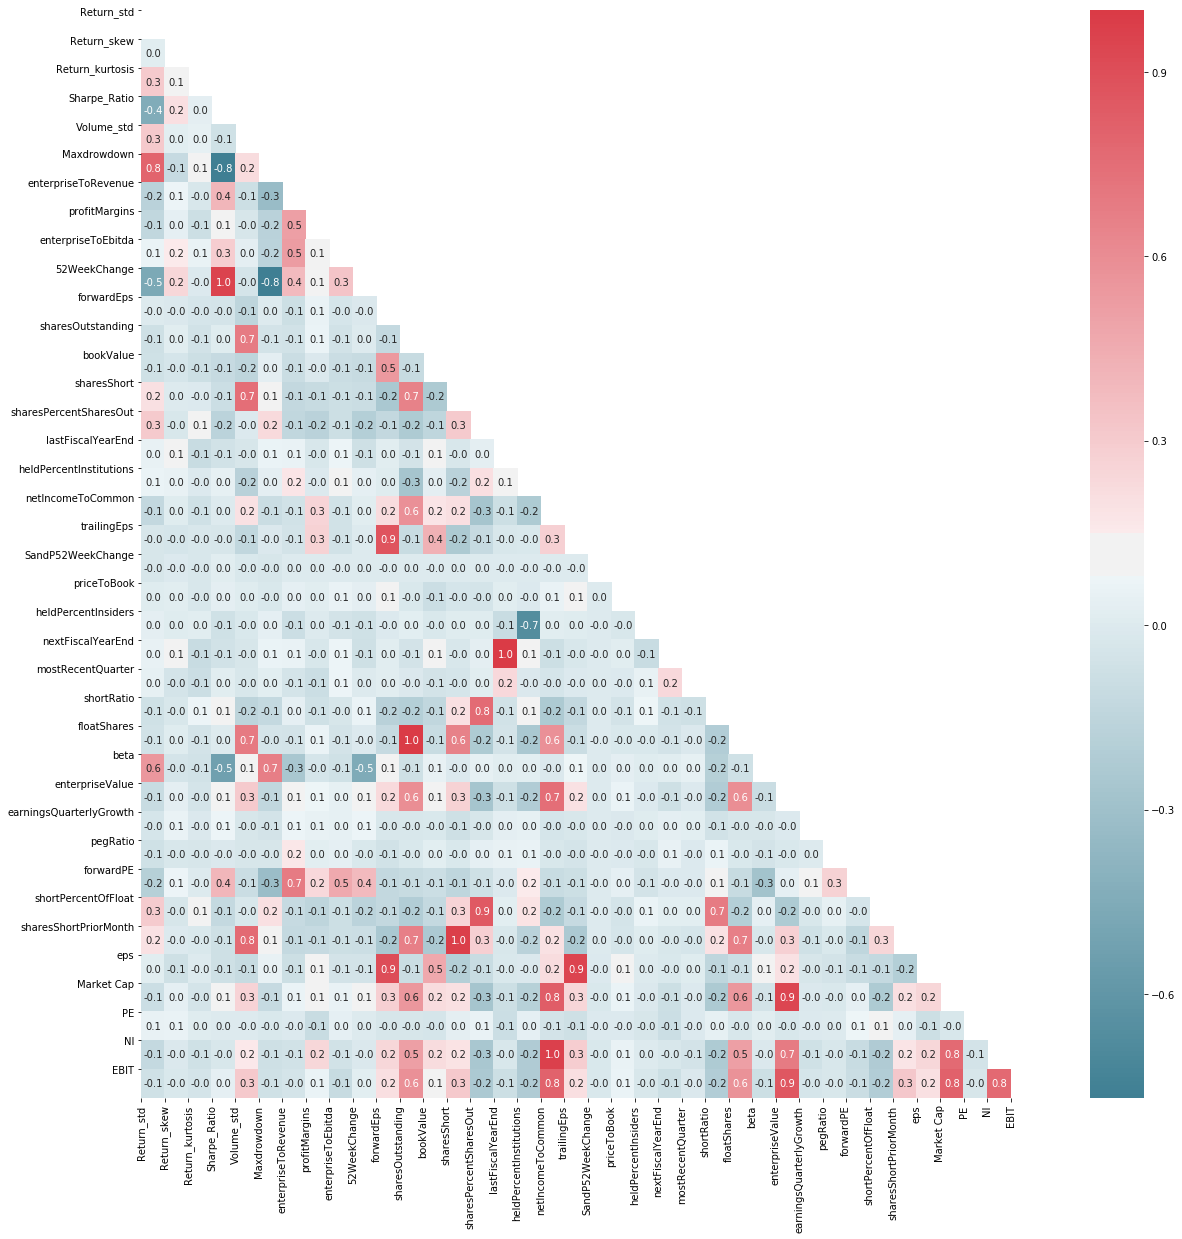

In [31]:
heatMap(train_df,False)

In [32]:
pca_feature = PCA(random_state=100)
_ = pca_feature.fit(train_df)

In [33]:
acc_va_ratio = np.cumsum(pca_feature.explained_variance_ratio_)
acc_va_ratio

array([0.17462808, 0.30465512, 0.41768906, 0.4819896 , 0.54359464,
       0.59457646, 0.63564344, 0.6754912 , 0.71043717, 0.74026469,
       0.7693771 , 0.79671374, 0.82311631, 0.84899496, 0.87137851,
       0.89267462, 0.9082734 , 0.9221877 , 0.93577494, 0.94607253,
       0.95550718, 0.96390272, 0.97035925, 0.97589429, 0.98093784,
       0.98516774, 0.98899167, 0.99182518, 0.99440853, 0.99642704,
       0.99735764, 0.99822195, 0.9989147 , 0.99947968, 0.9998442 ,
       0.99994546, 1.        , 1.        ])

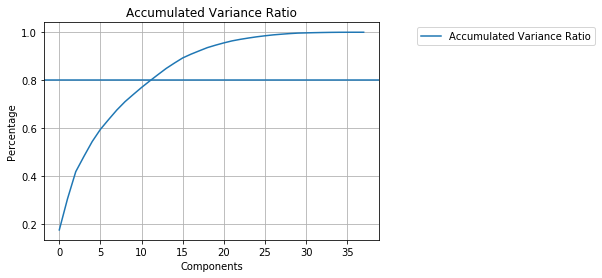

In [34]:
PCA_var_ratio=plt.figure()
plt.plot(acc_va_ratio)
plt.legend(["Accumulated Variance Ratio"],bbox_to_anchor=(1.1,1))
plt.grid()
plt.title("Accumulated Variance Ratio")
plt.xlabel('Components')
plt.ylabel('Percentage')
plt.axhline(y=0.8)
_ = plt.show()

In [35]:
m_pca = PCA(n_components=13).fit_transform(train_df)